We are going to use the RGB construction from [CEOS tutorial](http://ceos.org/document_management/SEO/DataCube/Laymans_SAR_Interpretation_Guide_2.0.pdf) to visualize our products. For ALOS1, we construct images with:

    Red = HH
    Green = HV
    Blue = HH/HV
    
and for UAVSAR:

    Red = HH
    Green = HV
    Blue = VV
    
For a standard RGB image.

In [1]:
import rasterio
import numpy
from rabasar import scale_img
from itertools import starmap
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

# Read Config File

In [2]:
config_dict = json.load(open('config.json', 'r'))
config_dict

{'sensor': 'alos1',
 'site': 'waxlake',
 'regularizer': 'bm3d',
 'spatial_weight': 0.05,
 'temporal_average_spatial_weight': 0.005,
 'ratio_weight': 0.05}

In [3]:
weight = .005
f'{weight:1.3f}'

'0.005'

In [4]:
SENSOR = config_dict['sensor']
SITE = config_dict['site']
REGULARIZER = config_dict['regularizer']
TA_SPATIAL_WEIGHT = config_dict['temporal_average_spatial_weight']
SPATIAL_WEIGHT = config_dict['spatial_weight']
RATIO_WEIGHT = config_dict['ratio_weight']

# Data Paths

In [5]:
data_dir_path_name = f'{SENSOR}_{SITE}/data_reprojected'
DATA_DIR = Path(data_dir_path_name)
DATA_DIR.exists()

True

In [6]:
RATIO_DIR =Path(f'out/{SENSOR}_{SITE}_{REGULARIZER}/rabasar_{REGULARIZER}')
RATIO_DIR.exists()

True

In [7]:
hh_paths_rabasar = sorted(list(RATIO_DIR.glob(f'final_weight_{RATIO_WEIGHT:1.3f}/hh/*hh*.tif')))
hv_paths_rabasar = sorted(list(RATIO_DIR.glob(f'final_weight_{RATIO_WEIGHT:1.3f}/hv/*hv*.tif')))
vv_paths_rabasar = sorted(list(RATIO_DIR.glob(f'final_weight_{RATIO_WEIGHT:1.3f}/vv/*vv*.tif')))

hh_paths_rabasar

[PosixPath('out/alos1_waxlake_bm3d/rabasar_bm3d/final_weight_0.050/hh/alos1_waxlake_hh_RTC_20071015_bm3d_weight_0.050.tif'),
 PosixPath('out/alos1_waxlake_bm3d/rabasar_bm3d/final_weight_0.050/hh/alos1_waxlake_hh_RTC_20080601_bm3d_weight_0.050.tif'),
 PosixPath('out/alos1_waxlake_bm3d/rabasar_bm3d/final_weight_0.050/hh/alos1_waxlake_hh_RTC_20080717_bm3d_weight_0.050.tif'),
 PosixPath('out/alos1_waxlake_bm3d/rabasar_bm3d/final_weight_0.050/hh/alos1_waxlake_hh_RTC_20080901_bm3d_weight_0.050.tif'),
 PosixPath('out/alos1_waxlake_bm3d/rabasar_bm3d/final_weight_0.050/hh/alos1_waxlake_hh_RTC_20081017_bm3d_weight_0.050.tif'),
 PosixPath('out/alos1_waxlake_bm3d/rabasar_bm3d/final_weight_0.050/hh/alos1_waxlake_hh_RTC_20090720_bm3d_weight_0.050.tif'),
 PosixPath('out/alos1_waxlake_bm3d/rabasar_bm3d/final_weight_0.050/hh/alos1_waxlake_hh_RTC_20091020_bm3d_weight_0.050.tif'),
 PosixPath('out/alos1_waxlake_bm3d/rabasar_bm3d/final_weight_0.050/hh/alos1_waxlake_hh_RTC_20100607_bm3d_weight_0.050.tif'),


In [13]:
ta_image_dir_name = f'out/{SENSOR}_{SITE}_{REGULARIZER}/temporally_averaged_image_{REGULARIZER}/weight_{TA_SPATIAL_WEIGHT:1.3f}'
TEMPORALLY_AVERAGED_IMAGE_DIR_TV = Path(ta_image_dir_name)
TEMPORALLY_AVERAGED_IMAGE_DIR_TV.exists()

True

In [14]:
ta_tv_paths = sorted(list(TEMPORALLY_AVERAGED_IMAGE_DIR_TV.glob('*.tif')))
ta_tv_paths

[PosixPath('out/alos1_waxlake_bm3d/temporally_averaged_image_bm3d/weight_0.005/waxlake_alos1_temporally_average_hh_bm3d_0.005.tif'),
 PosixPath('out/alos1_waxlake_bm3d/temporally_averaged_image_bm3d/weight_0.005/waxlake_alos1_temporally_average_hv_bm3d_0.005.tif')]

# Opening data

In [15]:
def open_one(path):
    with rasterio.open(path) as ds:
        img = ds.read(1)
    return img

ta_tv_reference_images = list(map(open_one, ta_tv_paths))

In [16]:
hv_ts = list(map(open_one, tqdm(hv_paths_rabasar)))
hh_ts = list(map(open_one, tqdm(hh_paths_rabasar)))
vv_ts = list(map(open_one, tqdm(vv_paths_rabasar)))

100%|██████████| 9/9 [00:00<00:00, 215.17it/s]
0it [00:00, ?it/s]


In [29]:
with rasterio.open(ta_tv_paths[0]) as ds:
    profile = ds.profile

# Subset and Display

In [19]:
if SITE == 'waxlake' and SENSOR == 'uavsar' and REGULARIZER == 'tv':
    sy = np.s_[-2000:-1000]
    sx = np.s_[-3000:-2000]
elif SITE == 'waxlake' and SENSOR == 'alos1' and REGULARIZER == 'tv':
    sy = np.s_[3_900:4_900]
    sx = np.s_[2_800:3_800]
elif REGULARIZER == 'bm3d':
    sy = sx = np.s_[:]
else:
    raise NotImplementedError

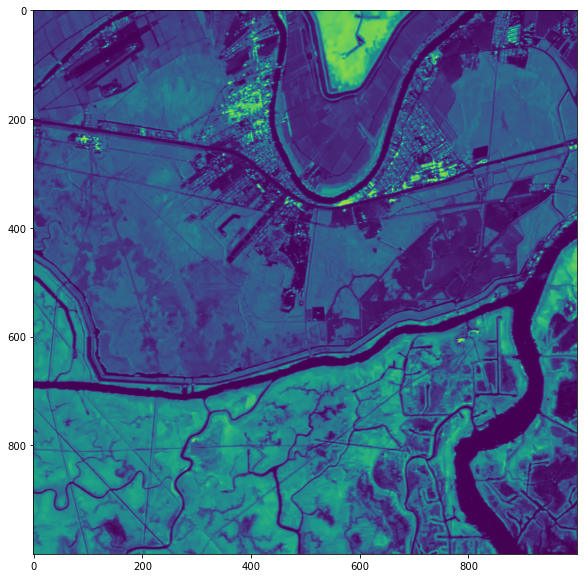

In [20]:
plt.figure(figsize=(10, 10))
plt.imshow(ta_tv_reference_images[0][sy, sx])

We select the image in the time series for testing.

In [21]:
IND = 1
mask = np.isnan(hh_ts[0])

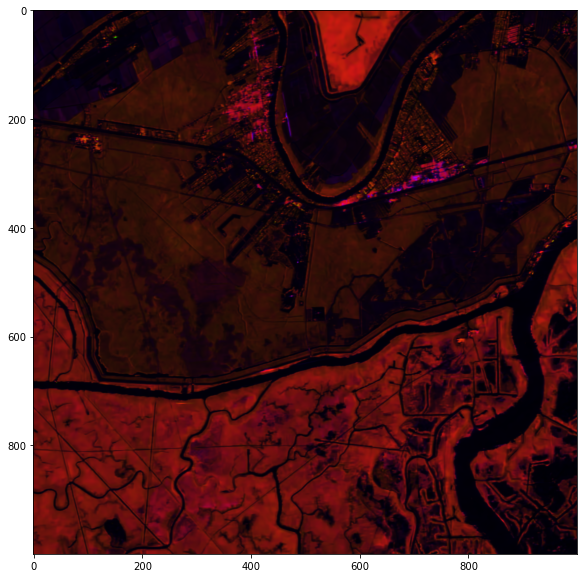

In [22]:
plt.figure(figsize=(10, 10))

if SENSOR == 'uavsar':
    rgb = np.stack([hh_ts[IND][sy, sx], 
                    hv_ts[IND][sy, sx], 
                    vv_ts[IND][sy, sx]],
                    axis=2)
    rgb = scale_img(rgb[sy, sx, :])
else:
    hh = scale_img(hh_ts[IND][sy, sx])
    hv = scale_img(hv_ts[IND][sy, sx])
    pol_ratio = hh_ts[IND][sy, sx] / np.clip(hv_ts[IND][sy, sx], 1e-3, 1)
    pol_ratio = scale_img(pol_ratio)
    rgb = np.stack([hh, 
                    hv, 
                    pol_ratio,
                   ],
                  axis=2)
    
plt.imshow(rgb)

# Obtain RGBs

## For time series

In [23]:
hh_names = list(map(lambda x: x.name, hh_paths_rabasar))
hv_names = list(map(lambda x: x.name, hv_paths_rabasar))
if SENSOR == 'uavsar':
    vv_names = list(map(lambda x: x.name, vv_paths_rabasar))

n = len(hv_names)
n

9

In [24]:
def make_rgb(*args):
    if SENSOR == 'uavsar':
        hh, hv, vv = args
        rgb = np.stack([hh, 
                        hv, 
                        vv],
                        axis=2)
        rgb = scale_img(rgb[sy, sx, :])
    else:
        hh, hv = args        
        hh = scale_img(hh)
        hv = scale_img(hv)
        pol_ratio = hh / np.clip(hv, 1e-3, 1)
        pol_ratio = scale_img(pol_ratio)
        rgb = np.stack([hh, 
                        hv, 
                        pol_ratio,
                       ],
                      axis=2)
    return rgb

ind = 0
if SENSOR == 'uavsar':
    rgb = make_rgb(hh_ts[ind], hv_ts[ind], vv_ts[ind])
else:
    rgb = make_rgb(hh_ts[ind], hv_ts[ind])

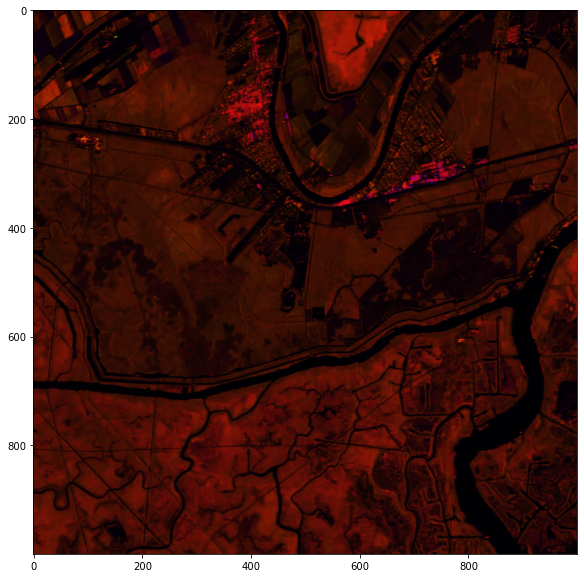

In [25]:
plt.figure(figsize=(10, 10))
plt.imshow(rgb[sy, sx, :])

In [26]:
rgb_dir = Path(f'out/{SENSOR}_{SITE}_{REGULARIZER}/rabasar_rgb_{REGULARIZER}_weight_{RATIO_WEIGHT:1.3f}')
rgb_dir.mkdir(exist_ok=True, parents=True)

In [27]:
def make_and_write_rgb(file_name, *args):
    rgb = make_rgb(*args)
    p_rgb = profile.copy()
    p_rgb['count'] = 3
    file_name = (file_name[:11] +
                 'rgb'+
                 file_name[13:-4]
                 + f'_weight_{RATIO_WEIGHT:1.3f}.tif')
    
    dest_path = rgb_dir/file_name
    with rasterio.open(dest_path, 'w', **p_rgb) as ds:
        ds.write(rgb.transpose([2, 0, 1]).astype(np.float32))
    return dest_path

In [30]:
if SENSOR == 'uavsar':
    list(starmap(make_and_write_rgb, zip(tqdm(hh_names), hh_ts, hv_ts, vv_ts)))
else:
    list(starmap(make_and_write_rgb, zip(tqdm(hh_names), hh_ts, hv_ts)))

100%|██████████| 9/9 [00:00<00:00, 10.38it/s]


# RGB Reference Image

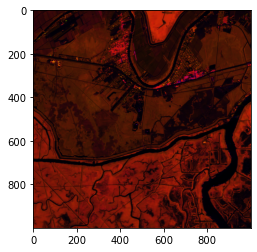

In [31]:
ta_reference_rgb = make_rgb(*ta_tv_reference_images)
plt.imshow(ta_reference_rgb[sy, sx, :])

In [32]:
dest_path = f'out/{SENSOR}_{SITE}_{REGULARIZER}/temporally_averaged_rgb_{REGULARIZER}_weight_{TA_SPATIAL_WEIGHT:1.3f}.tif'
p = profile.copy()
p['count'] = 3
with rasterio.open(dest_path, 'w', **p) as ds:
    ds.write(rgb.transpose([2, 0, 1]))